In [1]:
# Install pyspark
!pip install pyspark



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=e80239af25151cec5153175c6251cfc0047c4aceb7e25d54f1455056c1223db5
  Stored in directory: /root/.cache/pip/wheels/9f/34/a4/159aa12d0a510d5ff7c8f0220abbea42e5d81ecf588c4fd884
Successfully built pyspark


In [2]:
# Import SparkSession 
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
# Create a Spark Session and configure Spark context
spark=SparkSession.builder\
    .master("local[*]")\
    .appName("ML for Twitter Data")\
    .getOrCreate()
sc=spark.sparkContext
# Check spark session information
spark

In [3]:
# Mount (connect to) Google drive to be able to read from it (copy data files into HDFS)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Read dataset from google drive
df = spark.read.csv('/content/drive/My\ Drive/TwitterData_Prepared.csv', header = True, inferSchema = True)
# Cast boolean type to string type (because the pipeline.fit(df) just supports only integers and string )
from pyspark.sql.types import IntegerType
df = df.withColumn("default_profile",df.default_profile.cast(IntegerType()))
df = df.withColumn("default_profile_image",df.default_profile_image.cast(IntegerType()))
df = df.withColumn("geo_enabled",df.geo_enabled.cast(IntegerType()))
df = df.withColumn("verified",df.verified.cast(IntegerType()))
df = df.withColumn("has_description",df.has_description.cast(IntegerType()))
df = df.withColumn("has_lang",df.has_lang.cast(IntegerType()))
df = df.withColumn("has_background_image_url",df.has_background_image_url.cast(IntegerType()))
# Prints out the schema in the tree format.
df.printSchema()

root
 |-- default_profile: integer (nullable = true)
 |-- default_profile_image: integer (nullable = true)
 |-- tweets_like_by_user: integer (nullable = true)
 |-- followers_count: integer (nullable = true)
 |-- geo_enabled: integer (nullable = true)
 |-- verified: integer (nullable = true)
 |-- account_age_days: integer (nullable = true)
 |-- account_type: string (nullable = true)
 |-- has_description: integer (nullable = true)
 |-- has_lang: integer (nullable = true)
 |-- has_background_image_url: integer (nullable = true)



In [7]:
# Import pandas
import pandas as pd
# Eyeballing the first five rows of a PySpark DataFrame using take(), and creating a Pandas DataFrame with the resulting data using pd.DataFrame().
pd.DataFrame(df.take(5), columns = df.columns)

,default_profile,default_profile_image,tweets_like_by_user,followers_count,geo_enabled,verified,account_age_days,account_type,has_description,has_lang,has_background_image_url
0,0,0,4,1589,0,0,1403,bot,1,1,1
1,0,0,536,860,0,0,1379,human,1,1,1
2,0,0,3307,172,1,0,1159,human,1,1,1
3,1,0,8433,517,1,0,1489,human,1,1,0
4,0,0,88,753678,1,1,3138,human,1,1,1


In [ ]:
# Grouping data by the 'account_type' column and returning the count of occurrences using PySpark's DataFrame API,
# then converting the result to a Pandas DataFrame.
df.groupby('account_type').count().toPandas()

,account_type,count
0,human,25013
1,bot,12425


As we can see, according to the frequency the classes are imbalanced. So, it can affect the performance of the model. In this case, it may predict the majority class (human) more frequently, resulting in poor performance of the minority class (bot).
For this reason, we use the Resampling technique to deal with the biased data. In this case, we will under-sample the human class that has the most frequency.

In [60]:
from pyspark.sql.functions import rand

human_df = df.filter(df['account_type'] == 'human')

bot_df = df.filter(df['account_type'] == 'bot')

# get the count of the minority class (bot)
bot_count = bot_df.count()

# undersample the majority class (human)
human_sampled_df = human_df.sampleBy('account_type', fractions={ 'human': bot_count/human_df.count()}, seed=42)

# combine the undersampled majority class and minority class
balanced_df = bot_df.unionAll(human_sampled_df)

# shuffle the dataset
balanced_df = balanced_df.orderBy(rand())

In [38]:
# Grouping data by the 'account_type' column and returning the count of occurrences using PySpark's DataFrame API,
# then converting the result to a Pandas DataFrame.
balanced_df.groupby('account_type').count().toPandas()

,account_type,count
0,bot,12425
1,human,12503


Now we can see that the classes are balanced in the dataset.

In [43]:
# Eyeballing the first five rows of a PySpark DataFrame using take(), and creating a Pandas DataFrame with the resulting data using pd.DataFrame().
pd.DataFrame(balanced_df.take(5), columns = balanced_df.columns)

,default_profile,default_profile_image,tweets_like_by_user,followers_count,geo_enabled,verified,account_age_days,account_type,has_description,has_lang,has_background_image_url
0,0,0,963,226,1,0,4338,human,1,1,1
1,0,0,83374,5757,1,0,3511,human,1,1,1
2,1,0,1,193,0,0,1778,bot,1,1,1
3,1,0,115,3,0,0,3104,bot,1,1,1
4,0,0,44,7495,0,0,3688,bot,1,1,1


We calculate the summary statics for the numeric variables 

In [39]:
# We can manually select the numeric variables (only run one of these)
numeric_features = ['tweets_like_by_user', 'followers_count', 'account_age_days']

In [45]:
# Using the describe function to calculate the summary statistics of the numeric variables
balanced_df.select(numeric_features).describe().toPandas()

,summary,tweets_like_by_user,followers_count,account_age_days
0,count,24928,24928,24928
1,mean,10501.583961810013,284996.10261553276,2945.561416880616
2,stddev,32391.511232217297,2115930.308044962,1013.3340599014442
3,min,0,0,483
4,max,885123,121641473,5151


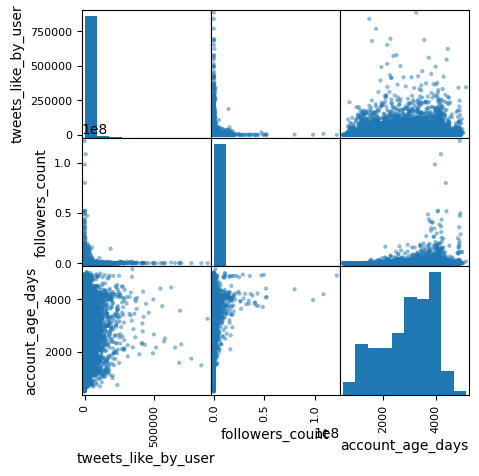

In [46]:
# Also, we can calculate and plot the correlations between the numeric variables:
# import the scatter_matrix function
from pandas.plotting import scatter_matrix
# converting the numeric features to Panadas dataframe and assigning them to variable
# numeric_data
numeric_data = balanced_df.select(numeric_features).toPandas()
# using scatter_matrix function to visualize the correlations between the numeric variables 
axs = scatter_matrix(numeric_data, figsize = (5, 5))

According to the result of the plot, there aren’t highly correlated numeric variables. In addition, "heatmap" can also be utilize to investigate the correlation between the numerical variables. To build the heatmap visualization, we will utilize the seaborn package:

Text(0.5, 1.0, 'Correlation Heatmap')

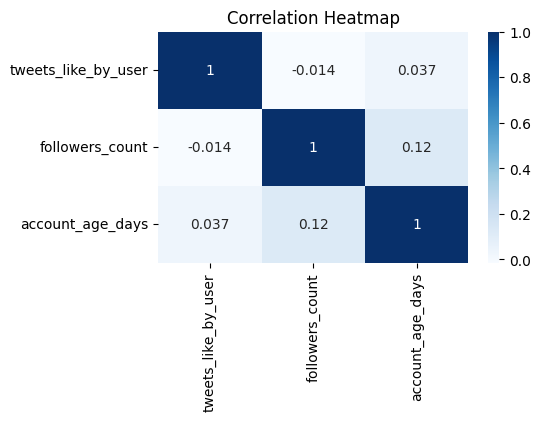

In [47]:
# seaborn package to generate the heatmap visualization for investigating the correlation between the numeric variables
import seaborn as sns 
import matplotlib.pyplot as plt
# creates a new figure object for a plot with a size of 5 inches by 3 inches.
fig = plt.figure(figsize = (5,3))
# creates a heatmap plot to visualize Pearson correlation of a numeric data using Seaborn library.
sns.heatmap(numeric_data.corr(method = 'pearson'), annot = True, cmap = "Blues")
# set title for figure
plt.title("Correlation Heatmap")

From the heatmap, we can see that there aren’t highly correlated numeric variables. Therefore, we will keep all of them for the modelling stage.



 the Spark ML library only works with numeric data, thus, we need to prepare the dataset to be used in the Machine Learning models.

In [48]:
# This part stores the column names of the DataFrame in a variable named "cols".
cols = balanced_df.columns
cols

['default_profile',
 'default_profile_image',
 'tweets_like_by_user',
 'followers_count',
 'geo_enabled',
 'verified',
 'account_age_days',
 'account_type',
 'has_description',
 'has_lang',
 'has_background_image_url']

In [50]:
# import the required functions
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler 
# select the categorical columns
categoricalColumns = ['default_profile','default_profile_image','geo_enabled','verified',
                      'has_description','has_lang','has_background_image_url']
# create empty list called stages that will be used to contain the results of StringIndexer and 
# OneHotEncoder
stages = []
# for loop to index each categorical column using the StringIndexer function. Then, the 
# OneHotEncoder function is used to convert indexed categorical variables into one-hot 
# encoded variables
for categoricalCol in categoricalColumns:
  stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
 # print(stringIndexer)
  encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()],outputCols=[categoricalCol + "classVec"]) 
 # print(encoder)
  stages = stages + [stringIndexer, encoder]
 # print(stages)
# we use the StringIndexer again to encode our labels to label indices 
label_stringIdx = StringIndexer(inputCol = 'account_type', outputCol = 'label') 
stages = stages + [label_stringIdx]
# print(stages)
# we use the VectorAssembler to combine all the feature columns into a single vector column.
numericCols = ['tweets_like_by_user','followers_count','account_age_days']  
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols 
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol = "features") 
stages = stages + [assembler]

In [51]:
# import Pipeline
from pyspark.ml import Pipeline
# steps to create the ML pipeline
pipeline = Pipeline(stages = stages) 
# fits a pipeline to a DataFrame "balanced_df".
pipelineModel = pipeline.fit(balanced_df)
# transforms a DataFrame "balanced_df" using the fitted PipelineModel "pipelineModel".
balanced_df = pipelineModel.transform(balanced_df) 
# creates a list "selectedCols" by concatenating column names 'label', 'features' and "cols".
selectedCols = ['label', 'features'] + cols 
# selects specific columns from a DataFrame and returns a new DataFrame with only those columns.
balanced_df = balanced_df.select(selectedCols)
# print the dataframe
balanced_df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- default_profile: integer (nullable = true)
 |-- default_profile_image: integer (nullable = true)
 |-- tweets_like_by_user: integer (nullable = true)
 |-- followers_count: integer (nullable = true)
 |-- geo_enabled: integer (nullable = true)
 |-- verified: integer (nullable = true)
 |-- account_age_days: integer (nullable = true)
 |-- account_type: string (nullable = true)
 |-- has_description: integer (nullable = true)
 |-- has_lang: integer (nullable = true)
 |-- has_background_image_url: integer (nullable = true)



In [53]:
# print DataFrame with the first 5 rows of an existing DataFrame and the same column names.
pd.DataFrame(balanced_df.take(5), columns = balanced_df.columns)

,label,features,default_profile,default_profile_image,tweets_like_by_user,followers_count,geo_enabled,verified,account_age_days,account_type,has_description,has_lang,has_background_image_url
0,0.0,"[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 963.0, 226...",0,0,963,226,1,0,4338,human,1,1,1
1,0.0,"[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 83374.0, 5...",0,0,83374,5757,1,0,3511,human,1,1,1
2,1.0,"[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 193.0...",1,0,1,193,0,0,1778,bot,1,1,1
3,1.0,"[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 115.0, 3.0...",1,0,115,3,0,0,3104,bot,1,1,1
4,1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 44.0, 7495...",0,0,44,7495,0,0,3688,bot,1,1,1


split the data frame into **Train/Test** 

In [54]:
# splits the "balanced_df" data frame into two data frames named "train" and "test" in a 7:3 ratio using a seed value of 213 for reproducibility.
train, test = balanced_df.randomSplit([0.7, 0.3], seed = 213)
# prints the count of rows in the DataFrames "train" and "test" to show the number of records in each dataset.
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 17402
Test Dataset Count: 7526


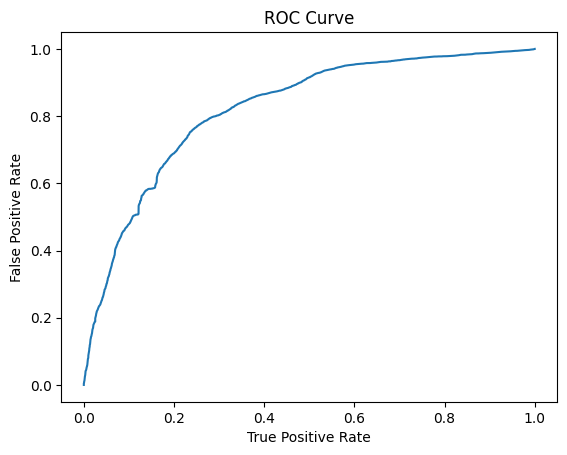

Training set Area Under ROC: 0.8216310226454899


In [55]:
# import LogisticRegression classifier
from pyspark.ml.classification import LogisticRegression
# configuring and training the Logistic Regression classifier using the training data 
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)
# calculate the statistics summary for the Logistic Regression model
trainingSummary = lrModel.summary
# plot the ROC curve from the calculated summary
roc = trainingSummary.roc.toPandas() 
# Plots the Receiver Operating Characteristic (ROC) curve using False Positive Rate (FPR) on the x-axis 
# - and True Positive Rate (TPR) on the y-axis, which are both columns in the 'roc' dataset.
plt.plot(roc['FPR'],roc['TPR']) 
# Sets the y-axis label to 'False Positive Rate'.
plt.ylabel('False Positive Rate')
# Sets the x-axis label to 'True Positive Rate'. 
plt.xlabel('True Positive Rate') 
# Sets the title of the plot to 'ROC Curve'.
plt.title('ROC Curve')
# Displays the ROC curve plot.
plt.show()
# Print Training set Area Under ROC
print('Training set Area Under ROC: ' + str(trainingSummary.areaUnderROC))

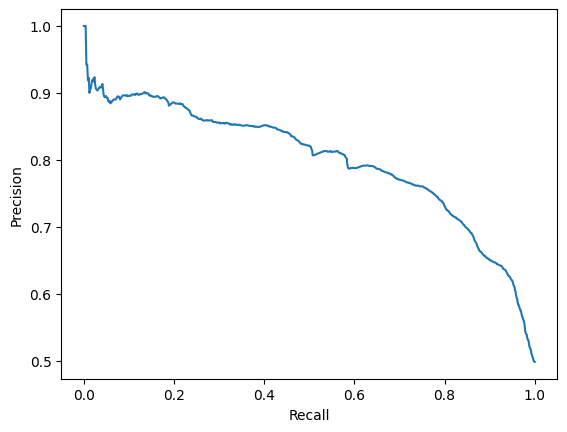

In [56]:
# converts a PySpark DataFrame to a pandas DataFrame.
pr = trainingSummary.pr.toPandas() 
# plots precision and recall values from a pandas DataFrame using matplotlib, and displays the plot.
plt.plot(pr['recall'],pr['precision']) 
plt.ylabel('Precision') 
plt.xlabel('Recall')
plt.show()


Next, we can test the performance of the Logistic Regression model using the test dataset:


In [57]:
# Testing the performance of the Logistic Regression classifier using the testing data
predictions = lrModel.transform(test)
# displays the first 5 rows of specified columns (label, prediction, rawPrediction, probability) from a DataFrame "predictions".
predictions.select('label', 'prediction', 'rawPrediction', 'probability').show(5)

+-----+----------+--------------------+--------------------+
|label|prediction|       rawPrediction|         probability|
+-----+----------+--------------------+--------------------+
|  0.0|       1.0|[-1.5707253271032...|[0.17211301520310...|
|  0.0|       1.0|[-1.5895370824427...|[0.16944903615864...|
|  0.0|       1.0|[-1.5845690225401...|[0.17014936998233...|
|  0.0|       1.0|[-1.5776398210633...|[0.17113000067311...|
|  0.0|       1.0|[-0.3266223728043...|[0.41906267811600...|
+-----+----------+--------------------+--------------------+
only showing top 5 rows



Now, we can measure the performance of the LR model:


In [58]:
# Import model evaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator 
# BinaryClassificationEvaluator object is being created
evaluator = BinaryClassificationEvaluator()
# Print Test Area Under ROC
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8210273850322437


In [59]:
# compute TN, TP, FN, and FP
predictions.groupBy('label', 'prediction').count().show()
# Calculate the elements of the confusion matrix
TN = predictions.filter('prediction = 0 AND label = prediction').count()
TP = predictions.filter('prediction = 1 AND label = prediction').count()
FN = predictions.filter('prediction = 0 AND label <> prediction').count()
FP = predictions.filter('prediction = 1 AND label <> prediction').count()
# calculate accuracy, precision, recall, and F1-score
accuracy = (TN + TP) / (TN + TP + FN + FP)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
F = 2 * (precision*recall) / (precision + recall)
# Print some information
print('n precision: %0.3f' % precision)
print('n recall: %0.3f' % recall)
print('n accuracy: %0.3f' % accuracy)
print('n F1 score: %0.3f' % F)

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 3039|
|  0.0|       1.0| 1192|
|  1.0|       0.0|  719|
|  0.0|       0.0| 2576|
+-----+----------+-----+

n precision: 0.718
n recall: 0.809
n accuracy: 0.746
n F1 score: 0.761
